In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin")

from src.data.Dataset import Dataset as DS
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Check if GPU is available

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [70]:
# Dataset generator
n = 10
m = 5
hop = 1/1200
input_dim   = 30 * n
pred_dim    = 0.25
shift       = pred_dim
batch_size  = 64
Data        = DS(
                input_dim, 
                pred_dim, 
                shift, 
                skip=0.25, 
                hop=hop, 
                batch_size=batch_size,
                in_cols=['roll','heave','pitch','wave'],
                out_cols=['roll','heave','pitch','wave']
                )

In [71]:
def trans_data(data):
    inp1 = data.map(lambda x, y: x)
    inp2 = data.map(lambda x, y: y[:, 0:, -1:])
    out = data.map(lambda x, y: y[:, :, :-1])

    trans_data_ = tf.data.Dataset.zip(((inp1, inp2),out))
    return trans_data_

def trans_dataset(Data):
    train = trans_data(Data.Train)
    val = trans_data(Data.Val)
    test = trans_data(Data.Test)
    return train, val, test

In [72]:
Train, Val, Test = trans_dataset(Data)

In [73]:
Train.element_spec

((TensorSpec(shape=(None, 1200, 4), dtype=tf.float64, name=None),
  TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None)),
 TensorSpec(shape=(None, 1, 3), dtype=tf.float64, name=None))

In [10]:
INPUT_DIM = Data.xshape
OUTPUT_DIM = Data.yshape

print('Input dim:', INPUT_DIM)
print('Output dim:', OUTPUT_DIM)

Input dim: [1200, 4]
Output dim: [1, 4]


In [74]:
# Loss functions

# Regression loss
MSE_loss = tf.keras.losses.MeanSquaredError()
MAE_loss = tf.keras.losses.MeanAbsoluteError()

# Metrics

# Regression metrics
MAPE = tf.keras.metrics.MeanAbsolutePercentageError()
MAE = tf.keras.metrics.MeanAbsoluteError()

In [75]:
input1 = tf.keras.Input(shape=(1200,4))
input2 = tf.keras.Input(shape=(1,1))

enc_lstm = tf.keras.layers.LSTM(units=256, return_state=True)
dec_lstm = tf.keras.layers.LSTM(units=256, return_sequences=False)
dense = tf.keras.layers.Dense(units=3)

x, *states = enc_lstm(input1)
inter = tf.concat([input1[:,-1:,:-1], input2], axis=-1)
x = dec_lstm(inter, initial_state=states)
out = dense(x)

model = tf.keras.Model((input1, input2), out)

In [76]:
# Compile model
LOSS = MSE_loss
METRICS = [MAPE, MAE]
LR = 1e-3

opt = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=opt, loss=LOSS, metrics=METRICS)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 1200, 4)]    0           []                               
                                                                                                  
 tf.__operators__.getitem_11 (S  (None, 1, 3)        0           ['input_33[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 input_34 (InputLayer)          [(None, 1, 1)]       0           []                               
                                                                                                  
 tf.concat_10 (TFOpLambda)      (None, 1, 4)         0           ['tf.__operators__.getitem_

In [77]:
# Check if model is working and the output shape

for x, y in Val.take(1):
    out = model(x)
    print(out.shape)

(64, 3)


In [78]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=15,
                                                    mode='min')

checkpoint_filepath = 'models/LSTM_encdec/04/model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="models/LSTM_encdec/04/metrics", update_freq=50)

In [79]:
model.fit(Val, epochs=100, validation_data=Test,callbacks=[early_stopping, model_checkpoint_callback, tensorboard_callback])

Epoch 1/100
   3976/Unknown - 713s 179ms/step - loss: 8.5000e-04 - mean_absolute_percentage_error: 203.0504 - mean_absolute_error: 0.0114

INFO:tensorflow:Assets written to: models/LSTM_encdec/04\model\assets


INFO:tensorflow:Assets written to: models/LSTM_encdec/04\model\assets


3976/3976 [==============================] - 1530s 384ms/step - loss: 8.5000e-04 - mean_absolute_percentage_error: 203.0504 - mean_absolute_error: 0.0114 - val_loss: 0.0010 - val_mean_absolute_percentage_error: 423.7542 - val_mean_absolute_error: 0.0128
Epoch 2/100
  24/3976 [..............................] - ETA: 12:22 - loss: 4.8467e-04 - mean_absolute_percentage_error: 201.0061 - mean_absolute_error: 0.0133

KeyboardInterrupt: 

In [ ]:
# Save model
# Uncomment to save model

# model_save_dir = 'models/LSTM_encdec/04/model'

# model.save(model_save_dir)

In [80]:
# Load model

model_dir = 'models/LSTM_encdec/04/model'

model = tf.keras.models.load_model(model_dir)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 1200, 4)]    0           []                               
                                                                                                  
 tf.__operators__.getitem_11 (S  (None, 1, 3)        0           ['input_33[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 input_34 (InputLayer)          [(None, 1, 1)]       0           []                               
                                                                                                  
 tf.concat_10 (TFOpLambda)      (None, 1, 4)         0           ['tf.__operators__.getitem_

In [11]:
val_performance = model.evaluate(Val)
test_performance = model.evaluate(Test)

18551/18551 [==============================] - 6528s 352ms/step - loss: 1.6821e-06 - mean_absolute_percentage_error: 1.7609 - mean_absolute_error: 3.3416e-04


In [20]:
print('Validation MSE_loss: {:.10f}'.format(val_performance[0]))
print('Validation MAPE:     {:.5f}'.format(val_performance[1]))
print('Validation MAE:      {:.5f}'.format(val_performance[2]))
print('Test MSE_loss:       {:.10f}'.format(test_performance[0]))
print('Test MAPE:           {:.5f}'.format(test_performance[1]))
print('Test MAE:            {:.5f}'.format(test_performance[2]))

Validation MSE_loss: 0.0000016963
Validation MAPE:     1.50507
Validation MAE:      0.00029
Test MSE_loss:       0.0000016821
Test MAPE:           1.76089
Test MAE:            0.00033


In [83]:
# Dataset generator
n = 10
m = 5
hop = 0.5
input_dim   = 30 * n
pred_dim    = 30 * n
shift       = pred_dim
batch_size  = 64
Data_inf        = DS(
                input_dim, 
                pred_dim, 
                shift, 
                skip=0.25, 
                hop=hop, 
                batch_size=batch_size,
                in_cols=['roll','heave','pitch','wave'],
                out_cols=['roll','heave','pitch','wave']
                )

In [85]:
def ARModel_Inference(x, y, OUT_dim = pred_dim*4, model=model):
    inp1 = x
    true_roll = y[:,:,0]
    pred_roll = []
    for i in range(OUT_dim):
        wave = y[:,i:i+1,-1:]
        INPUT = (inp1, wave[:,:,0:1])
        OUT = model(INPUT)
        RHP = tf.expand_dims(tf.cast(OUT, tf.float64), axis=1)
        HnP = y[:,i:i+1,1:3]
        temp = tf.concat([RHP, wave], axis = -1)
        inp1 = tf.concat([inp1[:,1:,:], temp], axis=1)
        pred_roll.append(RHP[:,:,0])

    pred_roll = tf.squeeze(tf.stack(pred_roll, axis=1), [-1]) 
    return true_roll, pred_roll


def save_inference(Data_inf, model=model, OUT_dim = pred_dim*4, save_dir=None):
    true_roll = []
    pred_roll = []
    inputs = []
    for x, y in Data_inf.take(2):
        t_r, p_r = ARModel_Inference(x, y, OUT_dim = OUT_dim, model=model)
        pred_roll.extend(p_r)
        true_roll.extend(t_r)
        inputs.extend(x)
        
    inputs = np.array(inputs)
    true_roll = np.array(true_roll)
    pred_roll = np.array(pred_roll)
    
#     if save_dir is not None:
#         if not os.path.isdir(save_dir):
#             os.mkdir(save_dir)
#         inp_path = save_dir + '/inputs.csv'
#         true_path = save_dir + '/true_roll.csv'
#         pred_path = save_dir + '/pred_roll.csv'
        
#         np.savetxt(inp_path, inputs[:,:,0], delimiter =", ")
#         np.savetxt(true_path, true_roll, delimiter =", ")
#         np.savetxt(pred_path, pred_roll[:,:,0], delimiter =", ")
        
        
    return inputs, true_roll, pred_roll
    


val_dir = 'models/LSTM_encdec/04/Val'
test_dir = 'models/LSTM_encdec/04/Test'


# test_in, test_true, test_pred = save_inference(Data_inf.Test, save_dir=test_dir)
val_in, val_true, val_pred = save_inference(Data_inf.Val, save_dir=val_dir)

In [82]:
def load_inference(folder):
    inputs    = np.genfromtxt(folder + '/inputs.csv', delimiter=', ', skip_header=0)
    true_roll = np.genfromtxt(folder + '/true_roll.csv', delimiter=', ', skip_header=0)
    pred_roll = np.genfromtxt(folder + '/pred_roll.csv', delimiter=', ', skip_header=0)
    
    return inputs, true_roll, pred_roll

In [14]:
test_in, test_true, test_pred = load_inference(test_dir)
val_in, val_true, val_pred = load_inference(val_dir)

In [18]:
print(val_in.shape)
print(val_true.shape)
print(val_pred.shape)

(414, 1200)
(414, 1200)
(414, 1200)


In [19]:
print(test_in.shape)
print(test_true.shape)
print(test_pred.shape)

(483, 1200)
(483, 1200)
(483, 1200)


In [86]:
def plot_inference(inputs, true, pred, nos, cut=0.5, units='deg'):
    n = inputs.shape[-1]
    n_plots = len(nos)
    cut_ind = int(n*cut)
    
    fac = 180/np.pi if units=='deg' else 1
    
    plt.figure(figsize=(18, n_plots*5))
    
    w1_end = inputs.shape[1]
    w2_size = true.shape[-1]*cut_ind
    t1 = np.array(range(0, w1_end))*0.25
    t2 = np.array(range(w1_end, w1_end + cut_ind))*0.25
    
    for i, ind in enumerate(nos):
        plt.subplot(n_plots, 1, i+1)
        plt.plot(t1, inputs[ind]*fac, label='Input')
        plt.plot(t2, true[ind,:cut_ind]*fac, label='True_roll')
        plt.plot(t2, pred[ind,:cut_ind]*fac, label='Pred_roll')
        plt.ylabel(f"Roll angle ({units})")
        plt.legend()
    plt.xlabel("Time (s)")    
    plt.show()    
    

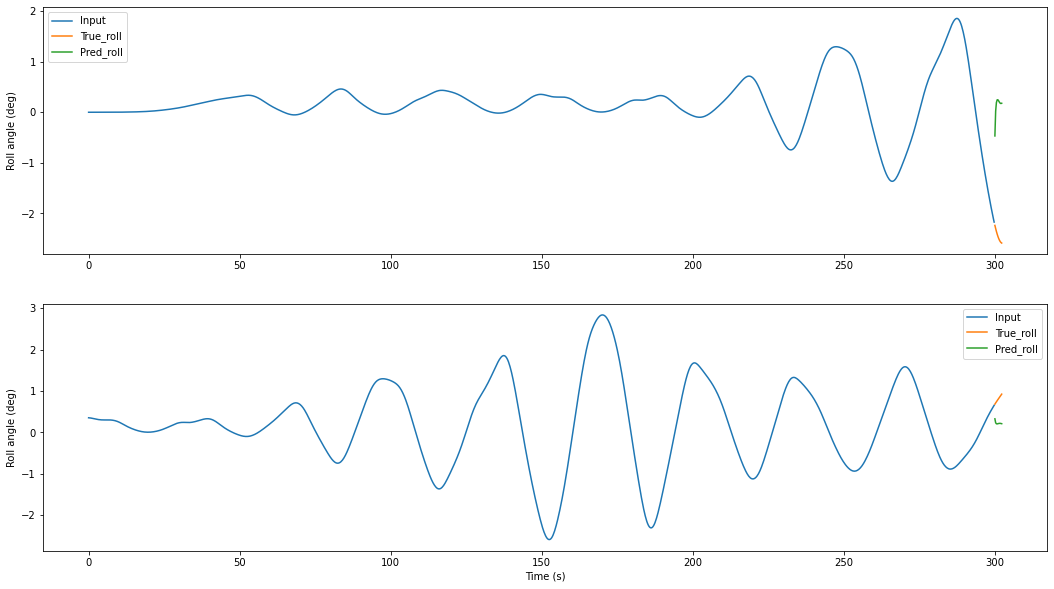

In [91]:
plot_inference(val_in[:,:,0], val_true, val_pred, nos=[0,1], cut=10/1200)

In [63]:
Train_inf, Val_inf, Test_inf = trans_dataset(Data_inf)

In [64]:
Val_inf.element_spec

((TensorSpec(shape=(None, 1200, 4), dtype=tf.float64, name=None),
  TensorSpec(shape=(None, 1200), dtype=tf.float64, name=None)),
 TensorSpec(shape=(None, 1200), dtype=tf.float64, name=None))

In [76]:
INPUT_DIM = [1200,4]
enc = [256]
dec = [256]
model = EncDec(enc, dec, 1200)

In [77]:
model_inf = model.load_weights('models/LSTM_encdec/03/model')

In [94]:
for x, y in Val_inf.take(1):
    pred_roll = model(x)
    true_roll = y
    inputs = x[0]

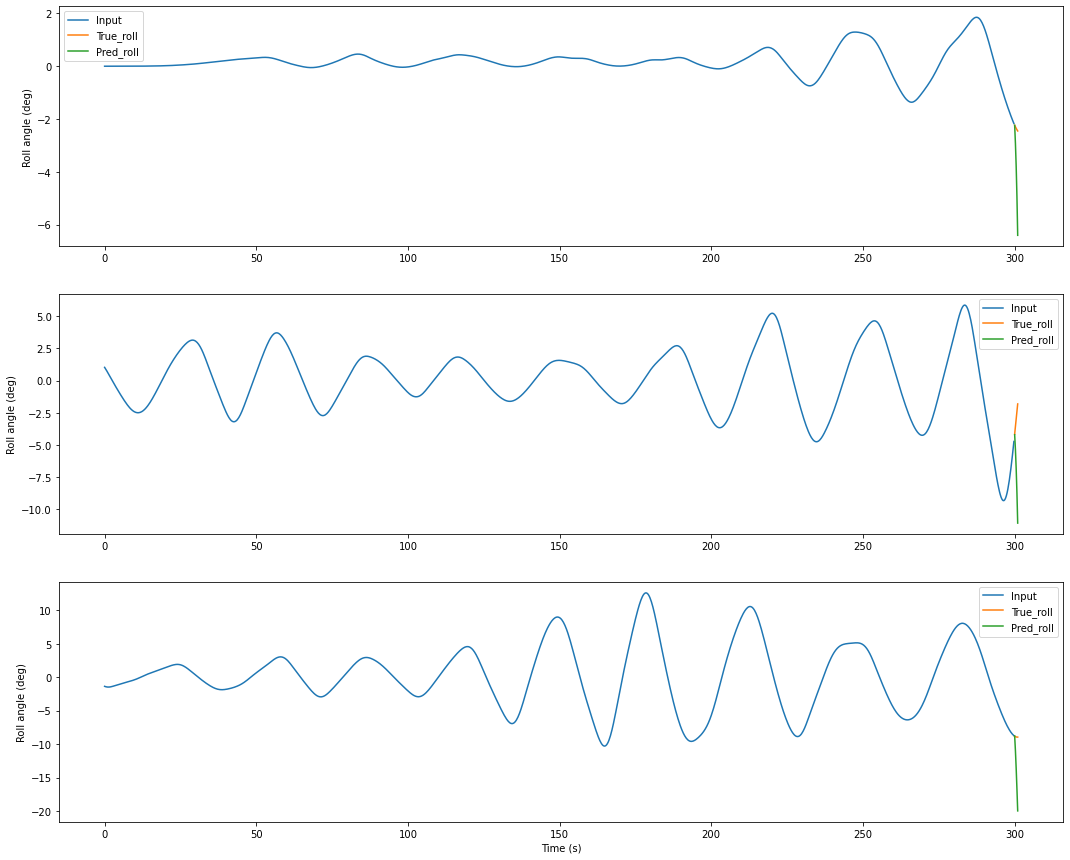

In [96]:
plot_inference(inputs[:,:,0], true_roll, pred_roll[:,:,0], [0, 10, 15], cut=5/1200)

In [88]:
pred_roll[0]

<tf.Tensor: shape=(1200, 1), dtype=float32, numpy=
array([[-0.03910951],
       [-0.05084831],
       [-0.06628109],
       ...,
       [-0.6655753 ],
       [-0.6655944 ],
       [-0.66562486]], dtype=float32)>

In [93]:
print(model_inf)